# COVID-19 - analysis and prediction  


### Table of Contents:  
1. [Checking the data](#Checking-the-data)
2. [Testing the data](#Testing-data)
3. [SVM](#SVM)
    - [Confirmed cases](#Confirmed-cases-SVM)
    - [Confirmed deaths](#Confirmed-deaths-SVM)
    - [Confirmed recoveries](#Confirmed-recoveries-SVM)
4. [Neural Network](#Neural-Network)
    - [Confirmed cases](#Confirmed-Cases-NN)
    - [Confirmed deaths](#Confirmed-deaths-NN)
    - [Confirmed recoveries](#Confirmed-recoveries-NN)
5. [Decision Tree](#Decision-Tree)
    - [Confirmed cases](#Confirmed-Cases-DT)
    - [Confirmed deaths](#Confirmed-deaths-DT)
    - [Confirmed recoveries](#Confirmed-recoveries-DT)

## Checking the data
First, it is required to analyse our dataset so that it is sure to not have any problems. To do so, we will print the first entries of the dataset:

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

data = pd.read_csv('data/covid19.csv', parse_dates=['Date'], infer_datetime_format=True)
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


The first problem we can identify is that some entries don't have a value on the *Country/Region* column.

We can fix this by assigning the value 'NA' to those entries:

In [2]:
# filling missing values 
data[['Province/State']] = data[['Province/State']].fillna('')
data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,,Angola,-11.2027,17.8739,2020-01-22,0,0,0


There were some comments on Kaggle about repeated lines, it seems this is not the case.

In [3]:
duplicated_rows = data.duplicated()
duplicated_rows[duplicated_rows == True]

Series([], dtype: bool)

We can now take a look at some summary statistics about the data set:

In [4]:
data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2430.562420,147.948752,607.899531
std,24.740912,70.570899,23545.664313,1561.525918,5210.234488
min,-51.796300,-135.000000,-1.000000,-1.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,184.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


We see that the count is the same for values in the columns *Lat*, *Long*, *Confirmed*, *Deaths* and *Recovered*.

There is, however, something strange with this dataset: The minimum value for *Confirmed* and *Deaths* is -1. Because negative values don't make sense for these two columns, we will use **mean imputation** to replace them with the average number for each column.

In [5]:
average_confirmed_count = data['Confirmed'].mean()
data.loc[(data['Confirmed'] < 0), 'Confirmed'] = average_confirmed_count

average_death_count = data['Deaths'].mean()
data.loc[(data['Deaths'] < 0), 'Deaths'] = average_death_count

data.describe()

,Lat,Long,Confirmed,Deaths,Recovered
count,25152.000000,25152.000000,25152.000000,25152.000000,25152.000000
mean,21.433571,22.597991,2432.399240,148.055347,607.899531
std,24.740912,70.570899,23545.569393,1561.520830,5210.234488
min,-51.796300,-135.000000,0.000000,0.000000,0.000000
25%,7.000000,-19.020800,0.000000,0.000000,0.000000
50%,23.659750,20.921188,6.000000,0.000000,0.000000
75%,41.204400,81.000000,185.000000,2.000000,18.000000
max,71.706900,178.065000,965785.000000,54881.000000,117727.000000


Now  those columns make more sense.

Also, to ensure data integrity, we will replace any missing values with 0s.

In [6]:
data[['Confirmed', 'Deaths', 'Recovered']] = data[['Confirmed', 'Deaths', 'Recovered']].fillna(0)

### Testing data

In [7]:
assert len(data.loc[(data['Deaths'] < 0)]) == 0

assert len(data.loc[(data['Confirmed'] < 0)]) == 0

assert len(data.loc[(data['Recovered'] < 0)]) == 0

It would be a shame to lose all this tidied up data. Let's save it.

In [8]:
data.to_csv('data/covid19_clean.csv', index=False)

We'll now take a look at the scatterplot matrix now that we've tidied the data:

In [9]:
data_clean = pd.read_csv('data/covid19_clean.csv')
data_clean.fillna(data_clean.mean(), inplace=True)
# sb.pairplot(data.dropna())

---

# SVM

In [10]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

import numpy as np

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

number_days_predict = 15

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

train_days = np.array(epidemic_days[0:-number_days_predict]).reshape(-1, 1)
test_days = np.array(epidemic_days[-number_days_predict:]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

train_cases =  np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_cases = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

train_deaths = np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_deaths = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

train_recovered = np.array(world_recovered[0:-number_days_predict]).reshape(-1, 1)
test_recovered = np.array(world_recovered[-number_days_predict:]).reshape(-1, 1)

## Confirmed cases SVM

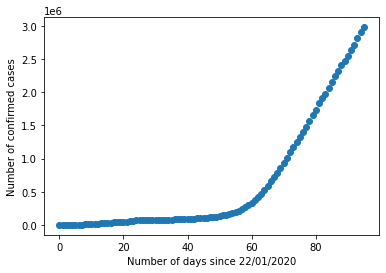

In [11]:
plt.scatter(x=epidemic_days, y=world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

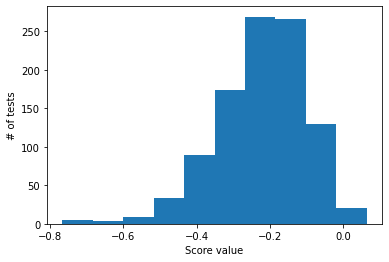

In [12]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

values = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_cases, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

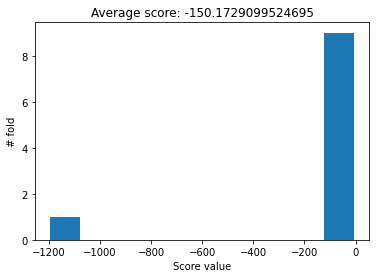

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_cases.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 6. After this we checked for the best combination for C and epsilon, and concluded that the lower the epsilon the better.  
With the epsilon fixed we then searched for the best combination of C and coef0.

*Beware this next block takes sometime to finish*

In [14]:
from sklearn.model_selection import GridSearchCV

svm = SVR(kernel='poly', degree=6, tol=1e-6, epsilon=0.001)

parameter_grid = {'C': np.arange(1, 40, 0.5),
                  'coef0': np.linspace(0.01, 1.0)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_cases.ravel())

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -57.929523665745215
Best parameters: {'C': 1.0, 'coef0': 0.13122448979591836}


In [15]:
svm_confirmed = grid_search.best_estimator_
print(svm_confirmed.get_params())

{'C': 1.0, 'cache_size': 200, 'coef0': 0.13122448979591836, 'degree': 6, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


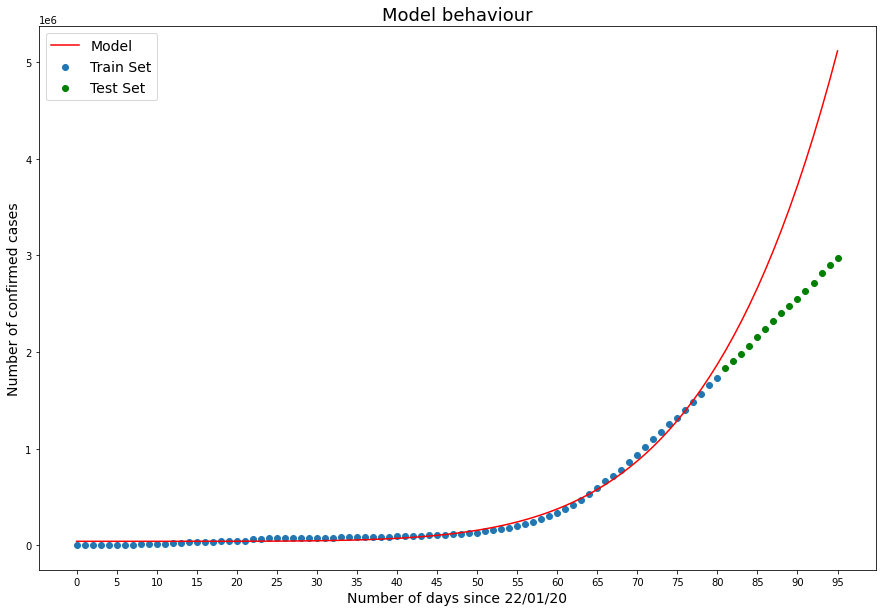

In [17]:
from sklearn.model_selection import cross_val_predict

pred = svm_confirmed.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_cases, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_cases.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of confirmed cases', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_confirmed.png')
plt.show()

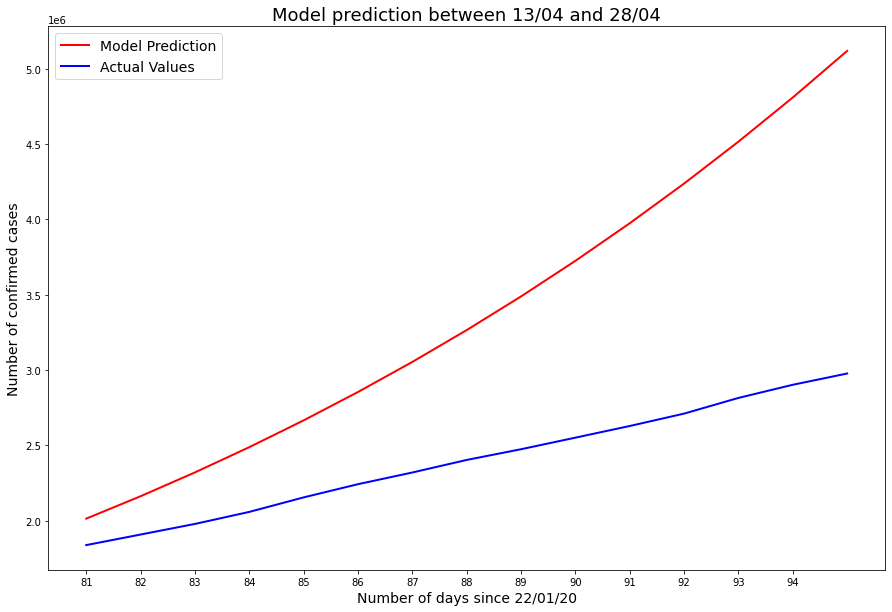

In [18]:
svr_pred_confirmed = svm_confirmed.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_confirmed, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_cases.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of confirmed cases', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_confirmed_pred.png')
plt.show()

### Model statistics

In [19]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_cases, svr_pred_confirmed)
mae = mean_absolute_error(test_cases, svr_pred_confirmed)
mse = mean_squared_error(test_cases, svr_pred_confirmed)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		2142039.274
Mean Absolute Error: 	982382.836
Mean Squared Error: 	1332834514838.546


## Confirmed deaths SVM

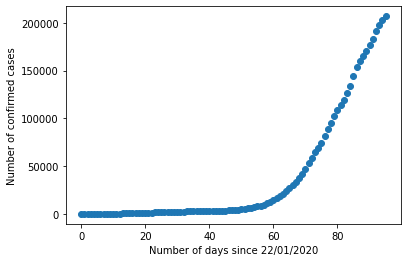

In [20]:
plt.scatter(x=epidemic_days, y=world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

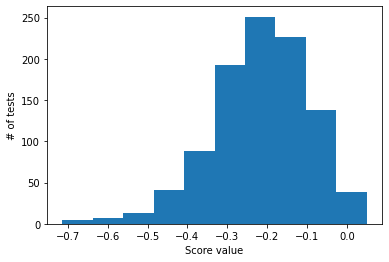

In [21]:
values = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_deaths, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

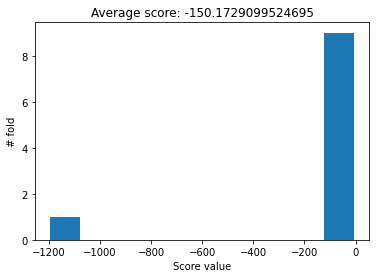

In [22]:
svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_deaths.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 5. After this we checked for the best combination for C and epsilon, contrary to what happened in the confirmed cases model here the lower epsilon didnt result in better results.  
With the epsilon fixed we then searched for the best combination of C and coef0.

*Beware this next block takes sometime to finish*

In [23]:
svm = SVR(kernel='poly', degree=5, tol=1e-6, epsilon=10)

parameter_grid = {'C': np.arange(1, 40, 0.5),
                  'coef0': np.linspace(0.01, 10)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_deaths.ravel())

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -27.63768414640136
Best parameters: {'C': 39.5, 'coef0': 3.679795918367347}


In [24]:
svm_deaths = grid_search.best_estimator_
print(svm_deaths.get_params())

{'C': 39.5, 'cache_size': 200, 'coef0': 3.679795918367347, 'degree': 5, 'epsilon': 10, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


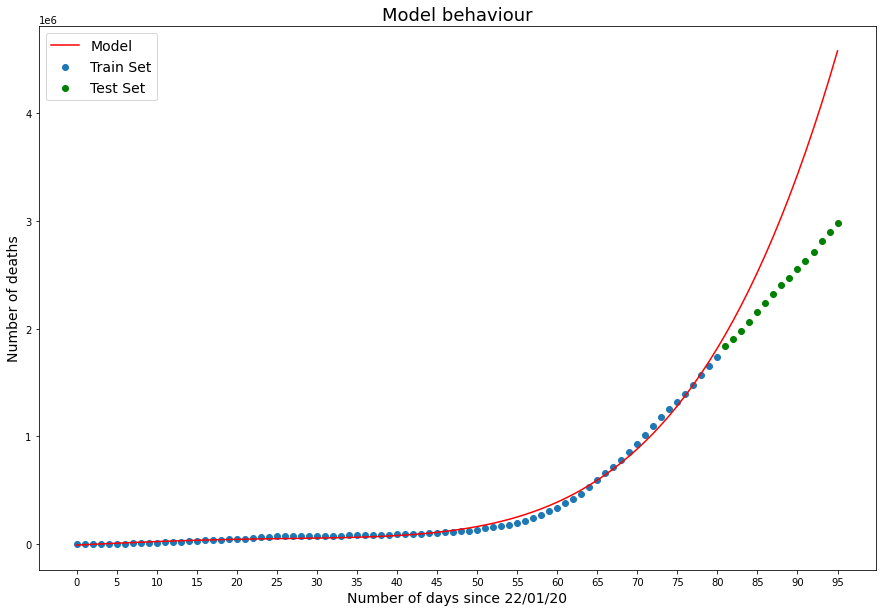

In [26]:
pred = svm_deaths.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_deaths, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_deaths.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of deaths', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_deaths_model.png')
plt.show()

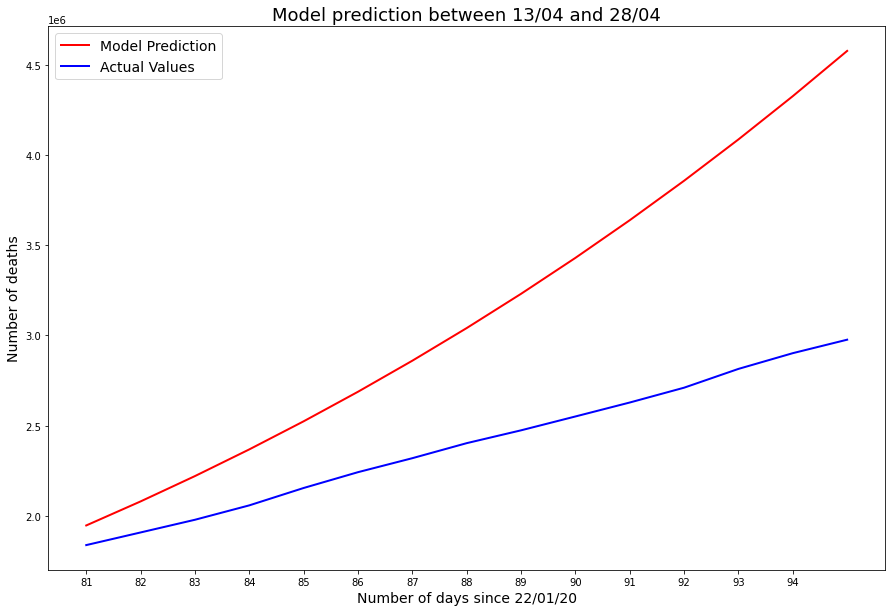

In [27]:
svr_pred_deaths = svm_deaths.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_deaths, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_deaths.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of deaths', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_deaths_pred.png')
plt.show()

### Model statistics

In [28]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_deaths, svr_pred_deaths)
mae = mean_absolute_error(test_deaths, svr_pred_deaths)
mse = mean_squared_error(test_deaths, svr_pred_deaths)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		1601655.943
Mean Absolute Error: 	728272.283
Mean Squared Error: 	742386552239.895


## Confirmed recoveries SVM

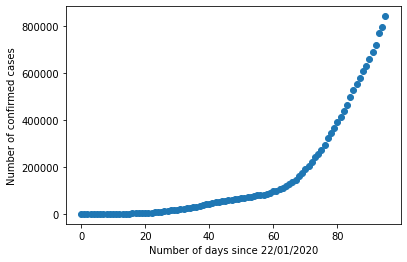

In [29]:
plt.scatter(x=epidemic_days, y=world_recovered)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, so we are using a polynomial kernel in SVM.
### Testing model for overfiting

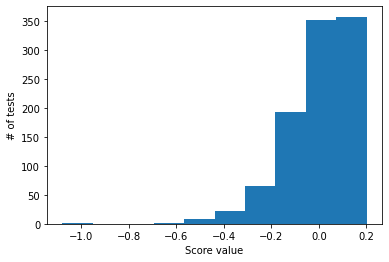

In [30]:
values = []

for repetition in range(1000):
    # Predict confirmed cases 
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(train_days, train_recovered, test_size=0.25) 
        
    svm = SVR(kernel='poly')
    svm.fit(X_train, y_train.ravel())
    scr = svm.score(X_test, y_test)
    values.append(scr)
    
plt.hist(values)
plt.xlabel('Score value')
plt.ylabel('# of tests')
plt.show()

It's obvious our model performs differently depending on the subset of data it's trained on. We can confirmed there is **overfitting** happening.  

### Testing for overfiting with K Folds

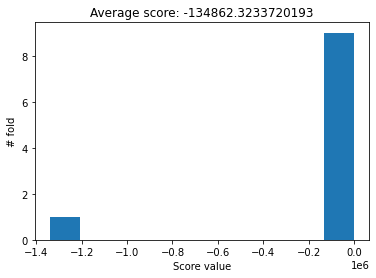

In [31]:
svm = SVR(kernel='poly')

cv_scores = cross_val_score(svm, 
                            train_days, 
                            train_recovered.ravel(), 
                            cv=10)

plt.ylabel('# fold')
plt.xlabel('Score value')
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

Using kfolds we were able to acheive a more consistant rating.  

Knowing this we can start to test with diferent parameters, in the 2 tests before we ran with defaults values for C and epsilon and a polynomial kernel.  
Now we are doing a grid search for the best values of C and epsilon. We are also spliting our data to have an independent set to test our model.  

Not all the tests done are present bellow, we started by checking the best value for the degree, using defaults for everything else, this ended up being 4. After this we checked for the best combination for C and epsilon. After this first test we noticed that the regression was well behaved, meaning it followed better the number of recoveries. We also noticed that the best value for epsilon was higher than the ones previously used.  
Since this model was well behaved the tests were quicker.

In [32]:
svm = SVR(kernel='poly', degree=4, tol=1e-6, C=32.5, epsilon=454)

parameter_grid = {'coef0': np.linspace(1.0, 2.0)}

grid_search = GridSearchCV(svm,
                           param_grid=parameter_grid,
                           cv=10)

grid_search.fit(train_days, train_recovered.ravel())

print('Best score: {}'.format(abs(grid_search.best_score_)))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 29.986501064486408
Best parameters: {'coef0': 1.8571428571428572}


In [33]:
svm_recoveries = grid_search.best_estimator_
print(svm_recoveries.get_params())

{'C': 32.5, 'cache_size': 200, 'coef0': 1.8571428571428572, 'degree': 4, 'epsilon': 454, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 1e-06, 'verbose': False}


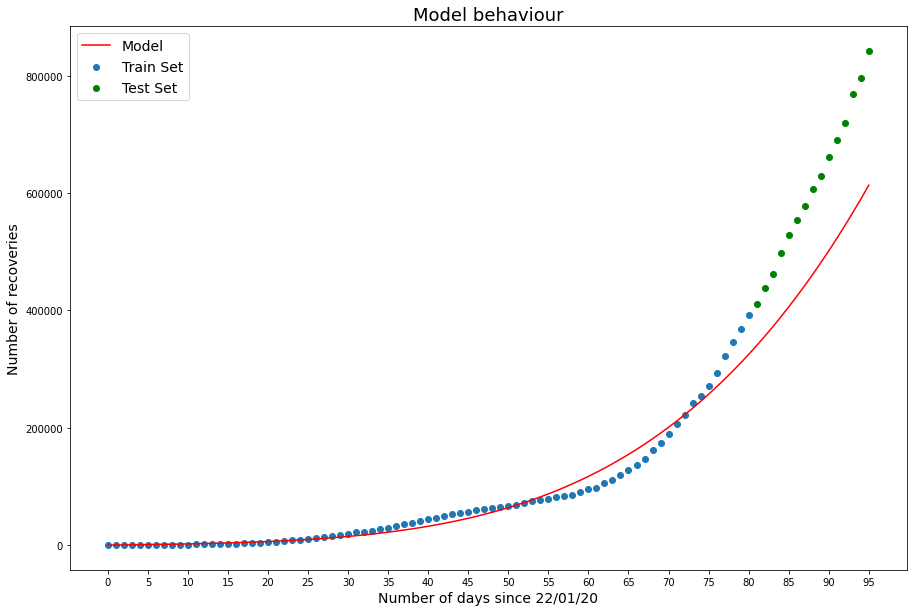

In [34]:
pred = svm_recoveries.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_recovered, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_recovered.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_recovered_model.png')
plt.show()

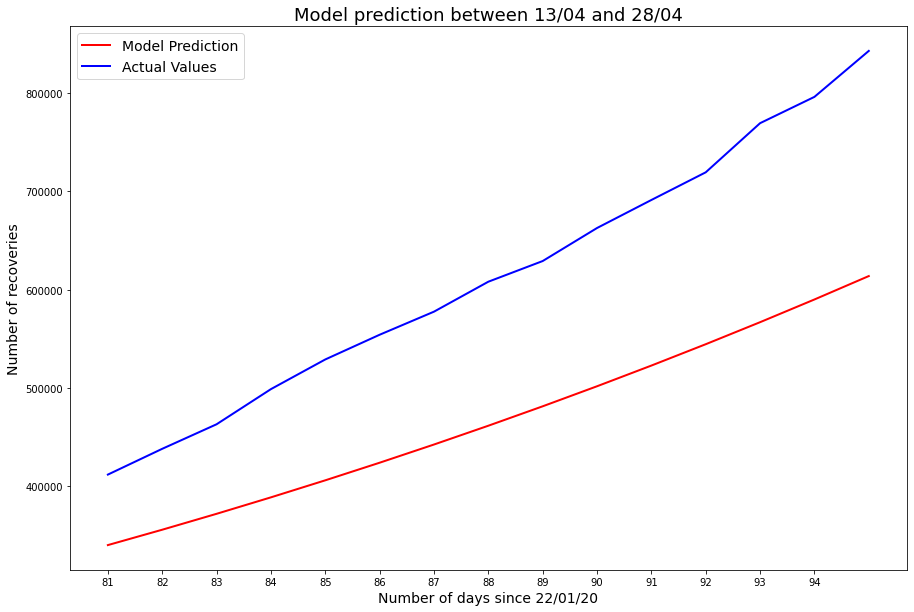

In [35]:
svr_pred_recoveries = svm_recoveries.predict(test_days)

plt.figure(figsize=(15, 10))
plt.plot(test_days, svr_pred_recoveries, color='red', label='Model Prediction', lw=2)
plt.plot(test_days, test_recovered.ravel(), color='blue', label='Actual Values', lw=2)
plt.xticks(np.arange(min(test_days), max(test_days), 1.0))
plt.title('Model prediction between 13/04 and 28/04', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/svr_recovered_pred.png')
plt.show()

### Model statistics

In [36]:
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score

max_error = max_error(test_recovered, svr_pred_recoveries)
mae = mean_absolute_error(test_recovered, svr_pred_recoveries)
mse = mean_squared_error(test_recovered, svr_pred_recoveries)

print('Max Error: \t\t{:0.3f}'.format(max_error))
print('Mean Absolute Error: \t{:0.3f}'.format(mae))
print('Mean Squared Error: \t{:0.3f}'.format(mse))

Max Error: 		229170.324
Mean Absolute Error: 	145387.601
Mean Squared Error: 	23142033248.139


# Neural Network

In [37]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense

ModuleNotFoundError: No module named 'keras'

In [ ]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

## Confirmed Cases NN

In [ ]:
plt.scatter(x=epidemic_days, y=world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, which the neural network is capable of predicting.

In [ ]:
dp_world_cases = world_cases.astype('float32')

We convert the data to floats because the neural network is more accurate with floats rather than integers

In [ ]:
# split into train and test sets
train_size = int(len(dp_world_cases) * 0.67)
test_size = len(dp_world_cases) - train_size
train, test = dp_world_cases[0:train_size], dp_world_cases[train_size:len(dp_world_cases)]
print(len(train), len(test))

We split the data in 2 parts, the first two thirds is for training and the remaining third for testing

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [ ]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_cases, look_back)
print(len(trainX), len(testX), len(finalX))

We create the dataset for training, in which each node contains the numbers of the previous 15 days, and the list with the correct answers.

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Here we are using a neural network with 15 inputs, a hidden layer with 8 nodes and 1 output. We are also training it

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Here we can see the performace of our neural network, both in the data that we used to train as well as with never previously seen data.

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_cases)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_cases)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_cases)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_cases)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

With this graph we can see that it actualy makes a good estimate for the values

In [ ]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_cases[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

Here we try to predict to the future of our data. Since the neural network only predicts the next day with the information of the previous 15 days what we do here is predict a day and use that prevision to generate the folowing predictions.

In [ ]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

Here we generate the list with all predictions made from the neural network

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_cases)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed cases')
plt.plot(allTest)
plt.show()

And here we can see the graph with all previsions made.

## Confirmed deaths NN

In [ ]:
plt.scatter(x=epidemic_days, y=world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed deaths')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, which the neural network is capable of predicting.

In [ ]:
dp_world_deaths = world_deaths.astype('float32')

We convert the data to floats because the neural network is more accurate with floats rather than integers

In [ ]:
# split into train and test sets
train_size = int(len(dp_world_deaths) * 0.67)
test_size = len(dp_world_deaths) - train_size
train, test = dp_world_deaths[0:train_size], dp_world_deaths[train_size:len(dp_world_deaths)]
print(len(train), len(test))

We split the data in 2 parts, the first two thirds is for training and the remaining third for testing

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [ ]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_deaths, look_back)
print(len(trainX), len(testX), len(finalX))

We create the dataset for training, in which each node contains the numbers of the previous 15 days, and the list with the correct answers.

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Here we are using a neural network with 15 inputs, a hidden layer with 8 nodes and 1 output. We are also training it

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Here we can see the performace of our neural network, both in the data that we used to train as well as with never previously seen data.

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_deaths)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_deaths)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_deaths)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_deaths)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

With this graph we can see that it actualy makes a good estimate for the values

In [ ]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_deaths[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

Here we try to predict to the future of our data. Since the neural network only predicts the next day with the information of the previous 15 days what we do here is predict a day and use that prevision to generate the folowing predictions.

In [ ]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

Here we generate the list with all predictions made from the neural network

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_deaths)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed deaths')
plt.plot(allTest)
plt.show()

And here we can see the graph with all previsions made.

## Confirmed recoveries NN

In [ ]:
plt.scatter(x=epidemic_days, y=world_recovered)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed recoveries')
plt.show()

From this graph we can see that the growth in numbers follows a polynomial function, which the neural network is capable of predicting.

In [ ]:
dp_world_recoveries = world_recovered.astype('float32')

We convert the data to floats because the neural network is more accurate with floats rather than integers

In [ ]:
# split into train and test sets
train_size = int(len(dp_world_recoveries) * 0.67)
test_size = len(dp_world_recoveries) - train_size
train, test = dp_world_recoveries[0:train_size], dp_world_recoveries[train_size:len(dp_world_deaths)]
print(len(train), len(test))

We split the data in 2 parts, the first two thirds is for training and the remaining third for testing

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# convert an array of values into a dataset matrix
def create_dataset_X(dataset, look_back=1):
	dataX = []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
	return np.array(dataX)

### Using the 15 previous days to forecast

In [ ]:
# reshape dataset
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
finalX = create_dataset_X(dp_world_recoveries, look_back)
print(len(trainX), len(testX), len(finalX))

We create the dataset for training, in which each node contains the numbers of the previous 15 days, and the list with the correct answers.

In [ ]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
# model.add(Dense(45, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=2, verbose=2)

Here we are using a neural network with 15 inputs, a hidden layer with 8 nodes and 1 output. We are also training it

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Here we can see the performace of our neural network, both in the data that we used to train as well as with never previously seen data.

In [ ]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dp_world_recoveries)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dp_world_recoveries)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dp_world_recoveries)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dp_world_recoveries)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

With this graph we can see that it actualy makes a good estimate for the values

In [ ]:
prevision =  []
for i in range(look_back):
    cur = []
    for j in range(look_back-i):
        cur.append(dp_world_recoveries[-look_back+i+j])
    for j in range(i):
        cur.append(np.array(([prevision[j]])))
    curnode = np.array(cur)
    curnode = np.array([curnode[:, 0]])
    pred = model.predict(curnode)
    prevision.append(pred[0])
prevision = np.array(prevision[:])

Here we try to predict to the future of our data. Since the neural network only predicts the next day with the information of the previous 15 days what we do here is predict a day and use that prevision to generate the folowing predictions.

In [ ]:
testFinal = model.predict(finalX)
beginFinal = np.array([ np.array([np.nan]) for i in range(look_back) ])
allTest = np.concatenate((beginFinal, testFinal, prevision))

Here we generate the list with all predictions made from the neural network

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(x=epidemic_days, y=dp_world_recoveries)
plt.xlabel('Number of days since 22/01/2020')
plt.ylabel('Number of confirmed recoveries')
plt.plot(allTest)

And here we can see the graph with all previsions made.

---

# Decision Tree

Although we cannot extrapolate values with the Decision Tree algorithm we still decided to implement it.  
This algorithm builds a tree where each node a decision is made, until a final decision is made at the leaf node. With this in mind, when we asked to predict how the next day, the next 15 days of the pandemic would be with this model, it was obvious it wouldn't work. The tree simply didn't have the necessary knowledge to predict that, it had no previous experience of how a day 100 would be in a covid19 pandemic.  

With all of this, this implementation still proved valuable since it made us figure out and understand the results we were seeing.

In [ ]:
inputs = data_clean[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered']].values
labels = data_clean[['Province/State', 'Country/Region', 'Date']].values

import numpy as np

dates = pd.unique(data_clean['Date'])
countries = pd.unique(data_clean['Country/Region'])

world_cases = []
world_deaths = []
world_recovered = []

number_days_predict = 15

for date in dates:
    confirmed = data_clean.loc[data_clean['Date'] == date, 'Confirmed']
    deaths = data_clean.loc[data_clean['Date'] == date, 'Deaths']
    recovered = data_clean.loc[data_clean['Date'] == date, 'Recovered']

    total_confirmed = confirmed.sum()
    total_deaths = deaths.sum()
    total_recovered = recovered.sum()
    
    world_cases.append(total_confirmed)
    world_deaths.append(total_deaths)
    world_recovered.append(total_recovered)

# Total days since the beggining of the epidemic
epidemic_days = np.array([i for i in range(len(dates))]).reshape(-1, 1)

train_days = np.array(epidemic_days[0:-number_days_predict]).reshape(-1, 1)
test_days = np.array(epidemic_days[-number_days_predict:]).reshape(-1, 1)

# Number of confirmed cases worldwide
world_cases = np.array(world_cases).reshape(-1, 1)

train_cases =  np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_cases = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of death counts worldwide
world_deaths = np.array(world_deaths).reshape(-1, 1)

train_deaths = np.array(world_cases[0:-number_days_predict]).reshape(-1, 1)
test_deaths = np.array(world_cases[-number_days_predict:]).reshape(-1, 1)

# Number of recovered patients worldwide
world_recovered = np.array(world_recovered).reshape(-1, 1)

train_recovered = np.array(world_recovered[0:-number_days_predict]).reshape(-1, 1)
test_recovered = np.array(world_recovered[-number_days_predict:]).reshape(-1, 1)

## Confirmed Cases DT

In [ ]:
from sklearn.tree import DecisionTreeRegressor
        
dt = DecisionTreeRegressor()

dt.fit(train_days, train_cases.ravel())
pred = dt.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_cases, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_cases.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/dt_confirmed.png')
plt.show()

As expected, with values unkonw do the tree, the prediction falls on the last leaf node of the tree corresponding to the last value of the training set.

## Confirmed deaths DT

In [ ]:
dt = DecisionTreeRegressor()

dt.fit(train_days, train_deaths.ravel())
pred = dt.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_deaths, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_deaths.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/dt_deaths.png')
plt.show()

## Confirmed recoveries DT

In [ ]:
dt = DecisionTreeRegressor()

dt.fit(train_days, train_recovered.ravel())
pred = dt.predict(epidemic_days)

plt.figure(figsize=(15, 10))
plt.scatter(x=train_days, y=train_recovered, label='Train Set')
plt.plot(pred, color='red', label='Model')
plt.scatter(test_days, test_recovered.ravel(), color='green', label='Test Set')
plt.xticks(np.arange(min(epidemic_days), max(epidemic_days)+3, 5.0))
plt.title('Model behaviour', fontsize=18)
plt.xlabel('Number of days since 22/01/20', fontsize=14)
plt.ylabel('Number of recoveries', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.savefig('graphs/dt_recovered.png')
plt.show()